# Data Wrangling - Vrije Universiteit Amsterdam - January Intensive 2020 #

Lanie Preston (VU Student Nr: 2629403)

Floor Kouwenberg (VU Student Nr: 2618232)

In [1]:
#read in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from matplotlib.ticker import FormatStrFormatter

## Data Retrieval

We will first import all the necessary datesets. We could get some of the datasets by downloading them from websites. However, other datasets got imported via their URL. Below we will import four datasets:
 * The US dairy production per year
 * The party division per year of the United States Congress
 * The dollar amount of subsidies given to dairy farmers per year by the US government
 * The dollar amount of lobbies from the dairy industry given to US politicians per year

### Annual Dairy Production ## 

In this section, we read in data from the USDA corresponding with the annual level of per capita milk production in the United Sates to examine how the American dairy industry has grown or shrunk over time. 

In [2]:
us_dairy_production = pd.read_excel('annualmilkprodfactors.xlsx', index_col=0)
us_dairy_production = us_dairy_production.dropna(axis=0)
milk_production =  us_dairy_production[['Milk production']]
milk_production

,Milk production
Year,
1980.0,128406.0
1981.0,132770.0
1982.0,135505.0
1983.0,139588.0
1984.0,135351.0
1985.0,143012.0
1986.0,143124.0
1987.0,142709.0
1988.0,145034.0


### Party Divisions in Congress ##

In this section, we read in data on how many Republicans and Democrats were in Congress per year to find the relative percentages of each party. 

In [3]:
senate_division = pd.read_html("https://en.wikipedia.org/wiki/Party_divisions_of_United_States_Congresses")[0].iloc[1100:1117]

#Selecting the right columns from the table. Also renaming the columns and removing the multi-index
senate_division = senate_division[["Years","Senate","Unnamed: 8_level_0", "House of Representatives"]]
senate_division.columns = senate_division.columns.droplevel(0)
senate_division = senate_division.drop(['Others', 'Vacancies', "Anti-Admin", "Pro-Admin", "Pro-Admin[3]"], axis=1)
senate_division.columns.values[1] = "Senate Democrats"
senate_division.rename({"Anti-Admin[2]": "Senate Republicans", "Unnamed: 8_level_1": "HOR Democrats", "Total": "HOR Republicans"}, axis='columns', inplace=True)

#Casting the values as integers
senate_division["Senate Democrats"] = senate_division["Senate Democrats"].astype(str).str[0:2].astype(int)
senate_division["Senate Republicans"] = senate_division["Senate Republicans"].astype(str).str[0:2].astype(int)
senate_division["HOR Democrats"] = senate_division["HOR Democrats"].astype(str).str[0:3].astype(int)
senate_division["HOR Republicans"] = senate_division["HOR Republicans"].astype(str).str[0:3].astype(int)
senate_division = senate_division.set_index("Years")

senate_division_per_year = pd.DataFrame(index=[], columns=senate_division.columns)

#Creating an annual table that states the division per year
for index, row in senate_division.iterrows():
    row.name = int(index.split("–")[0])
    senate_division_per_year = senate_division_per_year.append(row)
    row.name = row.name+1
    senate_division_per_year = senate_division_per_year.append(row)
    
senate_division_per_year = senate_division_per_year.fillna(0)
senate_division_per_year

,Senate Democrats,Senate Republicans,HOR Democrats,HOR Republicans
1987,55,45,258,177
1988,55,45,258,177
1989,55,45,260,175
1990,55,45,260,175
1991,56,44,267,167
1992,56,44,267,167
1993,57,43,258,176
1994,57,43,258,176
1995,47,53,204,230
1996,47,53,204,230


### Subsidies to Dairy Farmers ##

In this file we read in the dollar amount of annual subsidies paid from the US government to dairy farmers via two federal programs: Milk Income Loss Payments, which compensates farmers when milk prices drop below the price of milk in Boston, and the Dairy Margin Coverage Program, an opt-in program to compensate farmers whenever the price of milk falls below a farmer-specified level.

In [4]:
#read in separate excel files 
payouts2010 = pd.read_excel('GP_PaymentsUSA2010.xlsx')
payouts2000 = pd.read_excel('GP_PaymentsUSA2000.xlsx')
payouts1990 = pd.read_excel('GP_PaymentsUSA1990.xlsx')

#give all dfs sensible column names 
def clean_df(df):
    if 'Unnamed: 4' in list(df):
        del df['Unnamed: 4']
    df.rename(columns= {'Unnamed: 0': 'Program'}, inplace=True)
    df.rename(columns= {'United States': 'Program'}, inplace=True)
    return df

#clean all dataframes for merging 
payouts1990 = clean_df(payouts1990)
payouts2000 = clean_df(payouts2000)
payouts2010 = clean_df(payouts2010)


#mergint the payouts of all years
payouts_early = pd.merge(payouts1990, payouts2000, how='outer')
payouts_early = payouts_early.drop([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997], axis=1)
all_payouts = pd.merge(payouts_early, payouts2010, how='outer')

#Find all payouts that are related to the dairy industry
search_values = ['dairy','milk']
dairy_payouts = all_payouts[all_payouts['Program'].str.contains('|'.join(search_values),  na=False, case=False)]
dairy_payouts = dairy_payouts.set_index('Program')
dairy_payouts.columns = dairy_payouts.columns.map(int)
dairy_payouts = dairy_payouts.fillna(0)
dairy_payouts

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Program,,,,,,,,,,,,,,,,,,,,,
Milk income loss payments,0.0,0.0,0,0,859642,913317,205677,9587,431231,73902,...,51660.0,-100.0,446572.0,231704.0,-129.0,-40.0,-64.0,-43.0,-20.0,0.0
Dairy Margin Coverage Program,0.0,0.0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,686.0,10394.0,19.0,250013.0,214000.0


### Lobbies Paid to US Politicians by the Dairy Industry

Here we read in data on the dollar amount of lobbies, which are legal bribes paid by major industries such as pharmaceuticals and agriculture indirectly to US politicians. Lobbies are received by both Democrats and Republicans, but Republicans are statistically more often recipients of said bribes.

In [5]:
lobbies = pd.read_excel("AnnualLobbyingOnDairy.xlsx", index_cols=0)
lobbies_final = lobbies.pivot_table(columns='Year')
lobbies_final

Year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Total Lobbies,2245000,3051110,2798900,3260000,4314700,4073436,4839800,4841312,3840045,5220448,...,5662885,6695032,7302248,8347149,6951794,7116441,6480567,6009870,7590843,5637167


In [6]:
#Creating a table that contains the both lobbies and subsidies per year
all_funding = dairy_payouts.append(lobbies_final)
all_funding = all_funding.fillna(0)
all_funding

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Milk income loss payments,0.0,0.0,0,0,859642,913317,205677,9587,431231,73902,...,51660.0,-100.0,446572.0,231704.0,-129.0,-40.0,-64.0,-43.0,-20.0,0.0
Dairy Margin Coverage Program,0.0,0.0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,686.0,10394.0,19.0,250013.0,214000.0
Total Lobbies,2245000.0,3051110.0,2798900,3260000,4314700,4073436,4839800,4841312,3840045,5220448,...,5662885.0,6695032.0,7302248.0,8347149.0,6951794.0,7116441.0,6480567.0,6009870.0,7590843.0,5637167.0


## Data Visualization

#### Milk Production and Lobbies

<function matplotlib.pyplot.show(*args, **kw)>

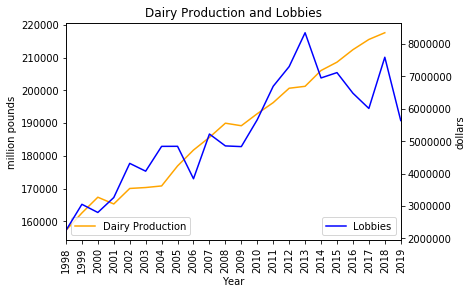

In [9]:
#isolate lobbies from funding dataframe
lobbies = all_funding.iloc[2]

#collect milk production data from  year and from the correct timeframe
sampled_production = milk_production.iloc[18:44]

#plot milk production and lobbies to Republicans on the same graph to see how they correlate 
ax1 = sampled_production.plot(color = 'orange', label="Dairy production", rot="vertical")
ax2 = lobbies.plot(secondary_y=True, color='blue', label="Lobbies", rot='vertical', xticks=lobbies.index)

ax1.legend(["Dairy Production"], loc=3)
ax2.legend(loc=4)
ax1.set(ylabel="million pounds")
ax1.right_ax.set_ylabel("dollars")
plt.title("Dairy Production and Lobbies")
plt.show

There is an identifiable correlation between annual dairy production in pounds and annual dollars spent on lobbies. This suggests that these lobbies successfully ensure laws are enacted that significantly aid dairy farmers, either financially or through a lack of industry regulation.

#### Milk Production and Subsidies

<function matplotlib.pyplot.show(*args, **kw)>

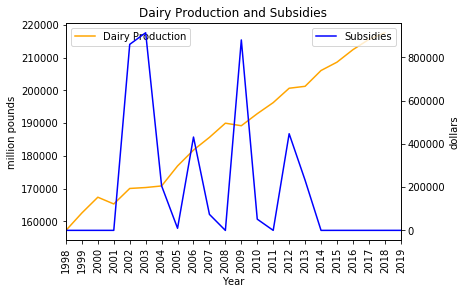

In [8]:
#select correct rows from government funding dataframe
subsidies= all_funding.iloc[0:1]

#select proper years from milk production dataframe
sampled_production = milk_production.iloc[18:41]

#plot milk production and Government Payouts to the Dairy Industry to see if they correlate 
ax1 = sampled_production.plot(color = 'orange', label="Dairy production", rot='vertical')
ax2 = subsidies.sum().plot(secondary_y=True, color='blue', label="Subsidies", xticks=lobbies.index, rot='vertical')

ax2.legend(loc=1)
ax1.legend(["Dairy Production"], loc=2)
ax1.set(ylabel="million pounds")
ax1.right_ax.set_ylabel("dollars")
plt.title("Dairy Production and Subsidies")
plt.show

Since the subsidy programs the USDA provides data on vary so widly in their payout amounts from year to year, there is no identifiable correlation between dairy production and subsidies.

#### Dairy Production Growth Rate and Lobbies

Since the growth rate of the US population could also affect its production, we decided to look at the growth rate of dairy production against annual lobbies and subsidies as well.

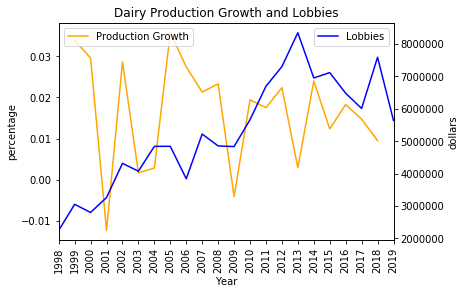

In [9]:
#Plot the growth of the milk industry versus dollar amounts of lobbies to the dairy industry per year.
production_growth = milk_production.iloc[18:42].pct_change()

ax = production_growth.plot(color = 'orange', label="Production Growth")
ax2 = lobbies.plot(secondary_y=True, color='blue', label="Lobbies", ax = ax, xticks=lobbies.index, rot='vertical')

ax.legend(["Production Growth"], loc=2)
ax.xaxis.set_ticks(sampled_production.index, 90)
ax2.legend(loc=1)
plt.title("Dairy Production Growth and Lobbies")
ax.set(ylabel="percentage")
ax.right_ax.set_ylabel("dollars")
plt.show()

When using growth rate rather than raw production values as a metric, dairy production no longer seems to correlate with lobbies.

#### Dairy Production Growth Rate and Subsidies

<function matplotlib.pyplot.show(*args, **kw)>

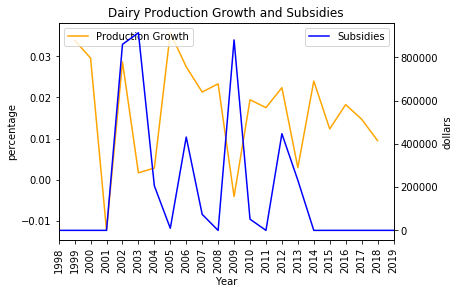

In [10]:
#plot the growth rate 
subsidies= all_funding.iloc[0:1]
sampled_production = milk_production.iloc[18:41]

ax = sampled_production.pct_change().plot(color = 'orange', label="Production growth")
ax2 = subsidies.sum().plot(secondary_y=True, color='blue', label="Subsidies",xticks=subsidies.columns, rot='vertical')

ax.legend(["Production Growth"], loc=2)
ax2.legend(loc=1)
plt.title("Dairy Production Growth and Subsidies")
ax.set(ylabel="percentage")
ax.right_ax.set_ylabel("dollars")
plt.show

Looking at this figure, we see a slight correlation between the annual growth rate of dairy production and subsidies, but not enough to suspect causation. 

#### Congress Division


The following plot shows which political party holds the majority of elected officials in Congress at each year. When the line is above the x-axis, it is red, meaning that Republicans hold the majority; when the line is below the x-axis, it is blue, meaning that Democrats hold the majority

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Congress Party Division')

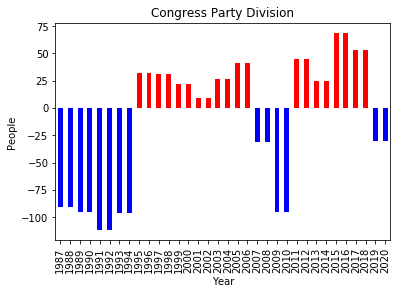

In [13]:
#plot congress division per year.
division = senate_division_per_year[["Senate Democrats", "Senate Republicans", 'HOR Republicans', "HOR Democrats"]]
division['Division'] = division['Senate Republicans']+division['HOR Republicans'] - division['Senate Democrats']- division['HOR Democrats']
ax1 = division['Division'].plot(color=(division['Division'] > 0).map({True: 'r', False: 'b'}), kind ='bar')

ax1.set(ylabel="People", xlabel = 'Year')
plt.title("Congress Party Division")

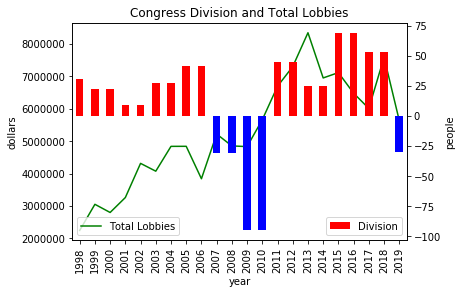

In [16]:
df1 = all_funding.iloc[[2]]
df2 = division[['Division']].iloc[11:33].T
df3 = df1.append(df2)
df3 = df3.T.reset_index()
df3 = df3.rename(columns={"index": "year"})

ax = df3[['year', 'Total Lobbies']].plot(x='year', color='g', use_index=False)
ax2 = df3[['year', 'Division']].plot(secondary_y=True, x='year', kind='bar', color=[np.where(df3["Division"]>0, 'r', 'b')], ax=ax)
ax.legend(loc = 3)
ax2.legend(loc = 4)
ax.set(ylabel="dollars")
ax.right_ax.set_ylabel("people")
plt.title("Congress Division and Total Lobbies")
plt.show()

This plot actually seems counterintuitive to our hypothesis as the growth rate for lobbies grows the most steeply during and immediately after a Democrat-majority Congress and falls again when Republicans take the majority again.

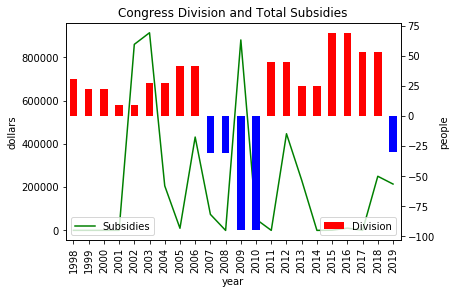

In [17]:
df1 = pd.DataFrame(all_funding.iloc[[0, 1]].sum())
df1 = df1.T
df2 = division[['Division']].iloc[11:33].T
df3 = df1.append(df2)
df3 = df3.T.reset_index()
df3 = df3.rename(columns={0: "Subsidies", "index": "year"})

ax = df3[['year', 'Subsidies']].plot(x='year', color='g', use_index=False)
ax2 = df3[['year', 'Division']].plot(secondary_y=True, x='year', kind='bar',  xticks=df3['year'], color=[np.where(df3["Division"]>0, 'r', 'b')], ax=ax)
ax.legend(loc = 3)
ax2.legend(loc = 4)
ax.set(ylabel="dollars")
ax.right_ax.set_ylabel("people")
plt.title("Congress Division and Total Subsidies")
plt.show()

This plot is difficult to interpret because of the nature of the data retrieved from the USDA. The two subsidy programs that the USDA provides data on are unpredictable and are not active every year within the timeframe we chose for this project.

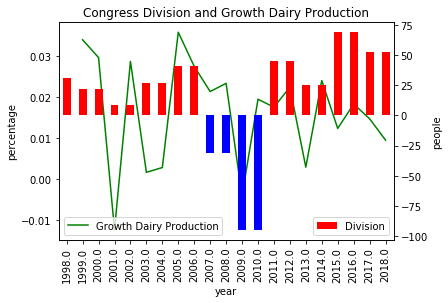

In [18]:
df1 = milk_production.iloc[18:44].pct_change()
df1 = df1.T
df2 = division[['Division']].iloc[11:32].T
df3 = df1.append(df2)
df3 = df3.T.reset_index()
df3 = df3.rename(columns={"index": "year","Milk production": "Growth Dairy Production"})


ax = df3[['year', 'Growth Dairy Production']].plot(x='year', color='g', use_index=False)
ax2 = df3[['year', 'Division']].plot(secondary_y=True, x='year', kind='bar',xticks=df3['year'], color=[np.where(df3["Division"]>0, 'r', 'b')], ax=ax)

ax.legend(loc = 3)
ax2.legend(loc = 4)
ax.set(ylabel="percentage")
ax.right_ax.set_ylabel("people")
plt.title("Congress Division and Growth Dairy Production")
plt.show()

This particular plot did match our hypothesis that a more Republican-heavy Congress would lead to increased dairy production as the dairy industry is more closely tied to the Republican party. The only exception is in 2001-2004 where the growth in dairy production spiked and dropped severely; more research would be required to find the cause for this.